In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('/Users/zoujingyi/Desktop/EDA/HI-Small_Trans.csv')

In [66]:
df.head()

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
0,2022/09/01 00:20,10,8000EBD30,10,8000EBD30,3697.34,US Dollar,3697.34,US Dollar,Reinvestment,0
1,2022/09/01 00:20,3208,8000F4580,1,8000F5340,0.01,US Dollar,0.01,US Dollar,Cheque,0
2,2022/09/01 00:00,3209,8000F4670,3209,8000F4670,14675.57,US Dollar,14675.57,US Dollar,Reinvestment,0
3,2022/09/01 00:02,12,8000F5030,12,8000F5030,2806.97,US Dollar,2806.97,US Dollar,Reinvestment,0
4,2022/09/01 00:06,10,8000F5200,10,8000F5200,36682.97,US Dollar,36682.97,US Dollar,Reinvestment,0


## Currency Adjusted

In [67]:
"""
Example usage:

    > usd_conversion = get_usd_conversion("/path/to/LI-Large_Trans.csv")
    > print(usd_conversion)

    {
        "US Dollar": 1.0,
        "Euro": 0.8533787417099838,
        "Yuan": 6.697677681891531,
        "Yen": 105.3976841187823,
        "UK Pound": 0.7739872068230277,
        "Brazil Real": 5.646327447497649,
        "Australian Dollar": 1.4127728666786938,
        "Canadian Dollar": 1.319260431085624,
        "Ruble": 77.79226317392629,
        "Mexican Peso": 21.1287988422576,
        "Rupee": 73.44399970830806,
        "Swiss Franc": 0.9149993127687566,
        "Shekel": 3.3769999188170305,
        "Saudi Riyal": 3.751098012020342,
        "Bitcoin": 8.333333333333333e-05,
    }

Or, provide the following argument to get the static currency
conversion rates (to skip generating the data each run):

    > usd_conversion = get_usd_conversion(
        "/path/to/LI-Large_Trans.csv",
        get_base_amlworld_data=True,
    )

"""

def extract_usd_conversion(
    currency_conversion: dict[str, dict[str, float]],
) -> dict[str, float]:
    """
    Given the result of `get_usd_conversion`, that is given a
    dictionary that maps each currency to its currency conversion
    rates, where each set of conversion rates may be incomplete,
    attempt to return a complete set of currency conversion rates
    for U.S. dollars
    """
    raise NotImplementedError(
        "This 'extract_usd_conversion' has not been implemented, because the "
        "data from the small transaction set provides a complete set of "
        " U.S. dollar conversion rates."
    )


def get_usd_conversion(dataset_dir: str, get_base_amlworld_data=False) -> dict[str, float]:
    """
    Given the name of a dataset, returns a currency conversion
    dictionary that will convert every value into U.S. dollars. This
    function currently only supports the AMLworld dataset and will fail
    to extract conversion rates from any dataset whose header does not
    match the AMLworld CSV datasets
    """
    data_header_mismatch = "Currency Conversion header mismatch"

    # To speed up use of this function, the following can be returned,
    # which is the result of running the method against the
    # `LI-Small_Trans.csv` data
    if get_base_amlworld_data:
        return {
            "US Dollar": 1.0,
            "Euro": 0.8533787417099838,
            "Yuan": 6.697677681891531,
            "Yen": 105.3976841187823,
            "UK Pound": 0.7739872068230277,
            "Brazil Real": 5.646327447497649,
            "Australian Dollar": 1.4127728666786938,
            "Canadian Dollar": 1.319260431085624,
            "Ruble": 77.79226317392629,
            "Mexican Peso": 21.1287988422576,
            "Rupee": 73.44399970830806,
            "Swiss Franc": 0.9149993127687566,
            "Shekel": 3.3769999188170305,
            "Saudi Riyal": 3.751098012020342,
            "Bitcoin": 8.333333333333333e-05,
        }

    # If we can't assume that every currency converts to every other currency
    # in the dataset, we need to create a partial conversion map for each
    # currency, and then aggregate the results into a single map for U.S.
    # dollar conversions
    currencies = set()
    currency_conversion = {}
    with open(dataset_dir, "r", encoding="utf-8") as file:
        header = True
        for line in file:
            columns = line.strip().split(",")

            # Checks that each data set is formatted with the expected data in
            # the same position
            if header:
                header = False
                if (
                    columns[5] != "Amount Received" or
                    columns[6] != "Receiving Currency" or
                    columns[7] != "Amount Paid" or
                    columns[8] != "Payment Currency"
                ):
                    raise ValueError(data_header_mismatch)
                continue

            sent_amount = columns[7]
            sent_currency = columns[8]
            received_amount = columns[5]
            received_currency = columns[6]

            currencies.add(sent_currency)
            currencies.add(received_currency)

            # To convert the sent currency to the received currency, multiply
            # it by this value
            conversion_rate = float(received_amount)/float(sent_amount)

            if sent_currency not in currency_conversion:
                currency_conversion[sent_currency] = {
                    sent_currency: 1.0
                }
            if received_currency not in currency_conversion[sent_currency]:
                currency_conversion[sent_currency][
                    received_currency
                ] = conversion_rate

    # See if we have a complete currency conversion map for U.S. dollars
    usd_conversion = currency_conversion["US Dollar"]
    if set(usd_conversion.keys()) == currencies:
        return usd_conversion
    return extract_usd_conversion(currency_conversion)

In [68]:
# Step 1: Get currency conversion rates
usd_conversion = get_usd_conversion('/Users/zoujingyi/Desktop/EDA/HI-Small_Trans.csv')

# Step 2: Apply conversion to the "Amount Received" column
df['Amount Received (USD)'] = df.apply(
    lambda row: row['Amount Received'] / usd_conversion.get(row['Receiving Currency'], 1.0),
    axis=1
)

In [69]:
df.head()

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering,Amount Received (USD)
0,2022/09/01 00:20,10,8000EBD30,10,8000EBD30,3697.34,US Dollar,3697.34,US Dollar,Reinvestment,0,3697.34
1,2022/09/01 00:20,3208,8000F4580,1,8000F5340,0.01,US Dollar,0.01,US Dollar,Cheque,0,0.01
2,2022/09/01 00:00,3209,8000F4670,3209,8000F4670,14675.57,US Dollar,14675.57,US Dollar,Reinvestment,0,14675.57
3,2022/09/01 00:02,12,8000F5030,12,8000F5030,2806.97,US Dollar,2806.97,US Dollar,Reinvestment,0,2806.97
4,2022/09/01 00:06,10,8000F5200,10,8000F5200,36682.97,US Dollar,36682.97,US Dollar,Reinvestment,0,36682.97


In [70]:
len(df)

5078345

## Without Feature engineering - can't run

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

# Prepare dataset for XGBoost
df = df.dropna(subset=['Is Laundering'])  # Drop missing target values

# Select features and target variable
X = df.drop(columns=['Is Laundering'])
y = df['Is Laundering']

# Convert categorical variables to dummy variables
X = pd.get_dummies(X, drop_first=True)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define XGBoost parameters
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'max_depth': 3,
    'eta': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}

# Train XGBoost model
num_round = 100
evals = [(dtrain, 'train'), (dtest, 'test')]
model = xgb.train(params, dtrain, num_round, evals, early_stopping_rounds=10, verbose_eval=True)

# Predict and evaluate
preds = model.predict(dtest)
pred_labels = (preds > 0.5).astype(int)

accuracy = accuracy_score(y_test, pred_labels)
auc = roc_auc_score(y_test, preds)

print(f"Accuracy: {accuracy:.4f}")
print(f"AUC: {auc:.4f}")

## With 2 covariate

In [2]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
import pandas as pd
import numpy as np

# Step 1: Prepare data
# Sample 0.1% of the data
df_sampled = df.sample(frac=1, random_state=42)

# Convert Timestamp to numerical feature
df_sampled['Timestamp'] = pd.to_datetime(df_sampled['Timestamp']).astype(int) / 10**9  # Convert to Unix timestamp

# Convert Payment Format to numerical codes
df_sampled['Payment Format'] = df_sampled['Payment Format'].astype('category').cat.codes

# Select features and target
X = df_sampled[['Timestamp', 'Payment Format']]
y = df_sampled['Is Laundering']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert dataset into DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define XGBoost parameters
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'max_depth': 8,
    'eta': 0.05,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}

# Train XGBoost model
num_round = 50
evals = [(dtrain, 'train'), (dtest, 'test')]
model = xgb.train(params, dtrain, num_round, evals, early_stopping_rounds=5, verbose_eval=True)

# Predict and evaluate
preds = model.predict(dtest)
pred_labels = (preds > 0.5).astype(int)

accuracy = accuracy_score(y_test, pred_labels)
auc = roc_auc_score(y_test, preds)

print(f"Accuracy: {accuracy:.4f}")
print(f"AUC: {auc:.4f}")

/Users/zoujingyi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:727: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	train-auc:0.87352	test-auc:0.87683
[1]	train-auc:0.89533	test-auc:0.89687
[2]	train-auc:0.89533	test-auc:0.89687
[3]	train-auc:0.89539	test-auc:0.89700
[4]	train-auc:0.87975	test-auc:0.88105
[5]	train-auc:0.89539	test-auc:0.89700
[6]	train-auc:0.89539	test-auc:0.89700
[7]	train-auc:0.89539	test-auc:0.89700
Accuracy: 0.9989
AUC: 0.8970


### 2 Covairate + Balance Data

[0]	train-auc:0.88642	test-auc:0.87968
[1]	train-auc:0.91065	test-auc:0.89475
[2]	train-auc:0.90848	test-auc:0.88722
[3]	train-auc:0.89469	test-auc:0.86550
[4]	train-auc:0.87739	test-auc:0.84665
[5]	train-auc:0.90980	test-auc:0.88782
[6]	train-auc:0.91315	test-auc:0.89377
Accuracy: 0.8551
AUC: 0.8938


/Users/zoujingyi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:727: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


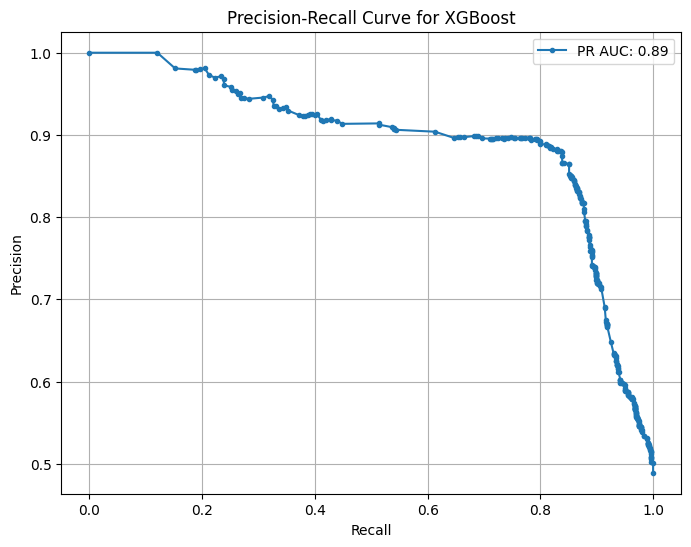

4062781 1015564
Illicit in Train: 3380 Illicit in Test: 1797


In [82]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, precision_recall_curve, auc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Prepare data
# didn't sample in this case
df_sampled = df

# Convert Timestamp to numerical feature
df_sampled['Timestamp'] = pd.to_datetime(df_sampled['Timestamp']).astype(int) / 10**9  # Convert to Unix timestamp

# Convert Payment Format to numerical codes
df_sampled['Payment Format'] = df_sampled['Payment Format'].astype('category').cat.codes

# Select features and target
X = df_sampled[['Timestamp', 'Payment Format']]
y = df_sampled['Is Laundering']

# Step 2: Balance the dataset using undersampling
df_minority = df_sampled[df_sampled['Is Laundering'] == 1]  # All illicit cases
df_majority = df_sampled[df_sampled['Is Laundering'] == 0].sample(n=len(df_minority), random_state=42)  # Sample same number of licit cases
df_balanced = pd.concat([df_majority, df_minority])

X_balanced = df_balanced[['Timestamp', 'Payment Format']]
y_balanced = df_balanced['Is Laundering']

# Step 3: Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

# Convert dataset into DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define XGBoost parameters
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'max_depth': 8,
    'eta': 0.05,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}

# Train XGBoost model
num_round = 50
evals = [(dtrain, 'train'), (dtest, 'test')]
model = xgb.train(params, dtrain, num_round, evals, early_stopping_rounds=5, verbose_eval=True)

# Predict and evaluate
preds = model.predict(dtest)
pred_labels = (preds > 0.5).astype(int)

accuracy = accuracy_score(y_test, pred_labels)
auc_score = roc_auc_score(y_test, preds)

print(f"Accuracy: {accuracy:.4f}")
print(f"AUC: {auc_score:.4f}")

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, preds)
pr_auc = auc(recall, precision)

# Plot PR Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label=f'PR AUC: {pr_auc:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for XGBoost')
plt.legend()
plt.grid()
plt.show()

print(len(df_train), len(df_test))
print("Illicit in Train:", df_train['Is Laundering'].sum(), 
      "Illicit in Test:", df_test['Is Laundering'].sum())

In [83]:
len(y_test)

2071

In [80]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
pred_labels = (preds > 0.5).astype(int)
cm = confusion_matrix(y_test, pred_labels)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Licit", "Illicit"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix for XGBoost Model")
plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [1015564, 2071]

### Prediction on LI csv

## Split Based on Timestamp - Account + Payment+ Timestamp

/var/folders/4z/4lgchhkd1154cdlhyxr67nn80000gn/T/ipykernel_67317/3070395669.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['Account'] = X_train['Account'].astype('category').cat.codes
/var/folders/4z/4lgchhkd1154cdlhyxr67nn80000gn/T/ipykernel_67317/3070395669.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['Account'] = X_test['Account'].astype('category').cat.codes


[0]	train-auc:0.87935	test-auc:0.89638
[1]	train-auc:0.93261	test-auc:0.90397
[2]	train-auc:0.93096	test-auc:0.91047
[3]	train-auc:0.92036	test-auc:0.90149


/Users/zoujingyi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:727: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[4]	train-auc:0.89557	test-auc:0.84784
[5]	train-auc:0.93370	test-auc:0.88789
[6]	train-auc:0.93564	test-auc:0.89033
Accuracy: 0.8376
AUC: 0.8915


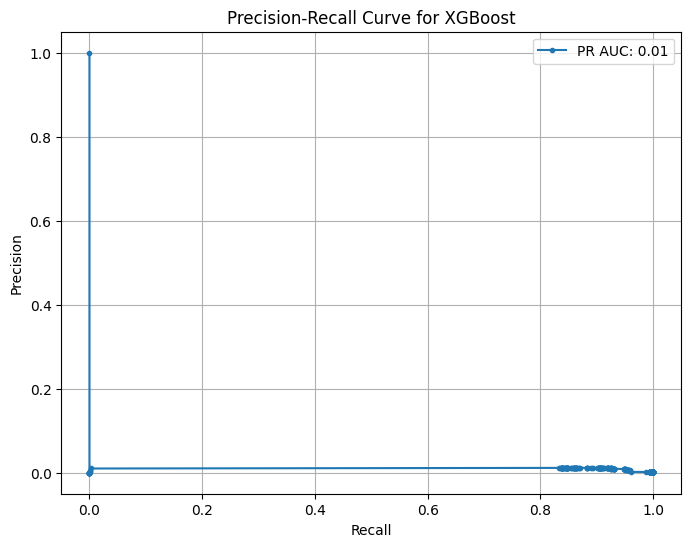

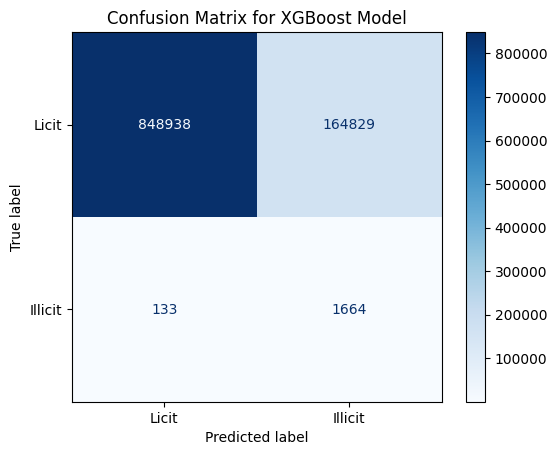

In [11]:
from sklearn.utils import resample

# Convert Timestamp to datetime
df_sampled['Timestamp'] = pd.to_datetime(df_sampled['Timestamp'])

# Define the train-test split point (e.g., 80% training, 20% testing)
split_date = df_sampled['Timestamp'].quantile(0.8)  # 80% quantile as split point

# Split into train and test sets based on Timestamp
df_train = df_sampled[df_sampled['Timestamp'] <= split_date]
df_test = df_sampled[df_sampled['Timestamp'] > split_date]

# Balance the training set using undersampling
df_minority_train = df_train[df_train['Is Laundering'] == 1]  # All illicit cases
df_majority_train = df_train[df_train['Is Laundering'] == 0]

# Undersample majority class to match the minority class count
df_majority_train_balanced = df_majority_train.sample(n=len(df_minority_train), random_state=42)

# Create the final balanced training set
df_train_balanced = pd.concat([df_majority_train_balanced, df_minority_train])

# Define features and target with 'Account' and 'Payment Format' instead of 'Timestamp'
X_train = df_train_balanced[['Account', 'Payment Format']]
y_train = df_train_balanced['Is Laundering']

X_test = df_test[['Account', 'Payment Format']]
y_test = df_test['Is Laundering']

# Convert categorical 'Account' to numerical encoding
X_train['Account'] = X_train['Account'].astype('category').cat.codes
X_test['Account'] = X_test['Account'].astype('category').cat.codes


# Convert dataset into DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define XGBoost parameters
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'max_depth': 8,
    'eta': 0.05,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}

# Train XGBoost model
num_round = 50
evals = [(dtrain, 'train'), (dtest, 'test')]
model = xgb.train(params, dtrain, num_round, evals, early_stopping_rounds=5, verbose_eval=True)

# Predict and evaluate
preds = model.predict(dtest)
pred_labels = (preds > 0.5).astype(int)

accuracy = accuracy_score(y_test, pred_labels)
auc_score = roc_auc_score(y_test, preds)

print(f"Accuracy: {accuracy:.4f}")
print(f"AUC: {auc_score:.4f}")

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, preds)
pr_auc = auc(recall, precision)

# Plot PR Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label=f'PR AUC: {pr_auc:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for XGBoost')
plt.legend()
plt.grid()
plt.show()

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
cm = confusion_matrix(y_test, pred_labels)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Licit", "Illicit"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix for XGBoost Model")
plt.show()

## Try with different features

In [62]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, auc
import numpy as np

def prepare_data(df, split_method, balance, features):
    """
    1. (Optionally) Balance the entire dataset FIRST by undersampling.
    2. Split into train/test based on chosen method (Random / Time).
    3. Select features & convert them if needed.
    """

    # Ensure Timestamp is a datetime
    #df['Timestamp'] = pd.to_datetime(df['Timestamp'])

    # 1. Balance the entire dataset first (if required)
    if balance:
        df_minority = df[df['Is Laundering'] == 1]
        df_majority = df[df['Is Laundering'] == 0]
        df_majority_balanced = df_majority.sample(n=len(df_minority), random_state=42)

        # Create the balanced DataFrame
        df = pd.concat([df_minority, df_majority_balanced])

    # 2. Train-test split based on chosen method
    if split_method == "Random":
        df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
    elif split_method == "Based on Time":
        # For time-based split, we pick the 80% quantile as cut-off
        split_date = df['Timestamp'].quantile(0.8)
        df_train = df[df['Timestamp'] <= split_date]
        df_test = df[df['Timestamp'] > split_date]

    # 3. Select features and target
    X_train = df_train[features].copy()
    X_test = df_test[features].copy()
    y_train = df_train['Is Laundering'].copy()
    y_test = df_test['Is Laundering'].copy()

    # Convert categorical features to numeric codes
    for col in features:
        # Handle object or categorical dtypes
        if X_train[col].dtype == 'object' or X_train[col].dtype.name == 'category':
            X_train[col] = X_train[col].astype('category').cat.codes
            X_test[col] = X_test[col].astype('category').cat.codes

    # Convert Timestamp to Unix time if it is in the selected features
    if 'Timestamp' in features:
        X_train['Timestamp'] = X_train['Timestamp'].astype(int) / 10**9
        X_test['Timestamp'] = X_test['Timestamp'].astype(int) / 10**9

    return X_train, X_test, y_train, y_test

def train_and_evaluate(X_train, X_valid, X_test, y_train, y_valid, y_test):
    """
    Trains an XGBoost model with a Validation Set and computes Precision-Recall AUC.
    """
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_valid, label=y_valid)
    dtest = xgb.DMatrix(X_test, label=y_test)

    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'max_depth': 8,
        'eta': 0.05,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'seed': 42
    }

    model = xgb.train(
        params,
        dtrain,
        num_boost_round=50,
        evals=[(dtrain, 'train'), (dvalid, 'valid')],  # Use validation set for early stopping
        early_stopping_rounds=5,
        verbose_eval=False
    )

    # Predict on the Test Set (Final Evaluation)
    preds = model.predict(dtest)

    # Compute Precision-Recall curve
    precision, recall, _ = precision_recall_curve(y_test, preds)
    pr_auc = auc(recall, precision)

    return pr_auc


# Example usage with multiple configurations
split_methods = ["Random", "Based on Time"]
balance_options = [True, False]
feature_combinations = [
    ['Timestamp', 'Payment Format'],
    ['From Bank', 'To Bank', 'Payment Format'],
    ['Timestamp', 'From Bank', 'To Bank', 'Payment Format'],
    ['Amount Received (USD)', 'Payment Format'],
    ['Amount Received (USD)', 'From Bank', 'To Bank', 'Payment Format'],
    ['Timestamp', 'Amount Received (USD)', 'From Bank', 'To Bank', 'Payment Format'],
]

results = []
for split_method in split_methods:
    for balance in balance_options:
        for features in feature_combinations:
            X_train, X_test, y_train, y_test = prepare_data(df, split_method, balance, features)
            pr_auc = train_and_evaluate(X_train, X_test, y_train, y_test)
            
            results.append({
                'Split Method': split_method,
                'Balance': 'Yes' if balance else 'No',
                'Features': ', '.join(features),
                'PR AUC': round(pr_auc, 3)
            })

results_df = pd.DataFrame(results)
print(results_df)

TypeError: train_and_evaluate() missing 2 required positional arguments: 'y_valid' and 'y_test'

In [94]:
results_df = results_df.sort_values(by='PR AUC', ascending=False).reset_index(drop=True)
results_df

,Split Method,Balance,Features,PR AUC
0,Based on Time,Yes,"Amount Received (USD), From Bank, To Bank, Pay...",0.992
1,Based on Time,Yes,"Timestamp, Amount Received (USD), From Bank, T...",0.990
2,Based on Time,Yes,"Amount Received (USD), Payment Format",0.987
3,Based on Time,Yes,"Timestamp, Payment Format",0.978
4,Based on Time,Yes,"Timestamp, From Bank, To Bank, Payment Format",0.976
5,Based on Time,Yes,"From Bank, To Bank, Payment Format",0.975
6,Random,Yes,"Amount Received (USD), From Bank, To Bank, Pay...",0.959
7,Random,Yes,"Timestamp, Amount Received (USD), From Bank, T...",0.958
8,Random,Yes,"Amount Received (USD), Payment Format",0.935
9,Random,Yes,"From Bank, To Bank, Payment Format",0.927


In [95]:
filtered_results_df = results_df[
    ~((results_df['Split Method'] == 'Based on Time') & results_df['Features'].str.contains('Timestamp'))
]
filtered_results_df

,Split Method,Balance,Features,PR AUC
0,Based on Time,Yes,"Amount Received (USD), From Bank, To Bank, Pay...",0.992
2,Based on Time,Yes,"Amount Received (USD), Payment Format",0.987
5,Based on Time,Yes,"From Bank, To Bank, Payment Format",0.975
6,Random,Yes,"Amount Received (USD), From Bank, To Bank, Pay...",0.959
7,Random,Yes,"Timestamp, Amount Received (USD), From Bank, T...",0.958
8,Random,Yes,"Amount Received (USD), Payment Format",0.935
9,Random,Yes,"From Bank, To Bank, Payment Format",0.927
10,Random,Yes,"Timestamp, From Bank, To Bank, Payment Format",0.925
11,Random,Yes,"Timestamp, Payment Format",0.921
13,Random,No,"Timestamp, Payment Format",0.441


### Train + Test + Validation

In [93]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, auc
import numpy as np

def prepare_data(df, split_method, balance, features):
    """
    1. (Optionally) Balance the entire dataset FIRST by undersampling.
    2. Split into train/validation/test based on chosen method (Random / Time).
    3. Select features & convert them if needed.
    """

    # Ensure Timestamp is a datetime
    # df['Timestamp'] = pd.to_datetime(df['Timestamp'])

    # 1. Balance the entire dataset first (if required)
    if balance:
        df_minority = df[df['Is Laundering'] == 1]
        df_majority = df[df['Is Laundering'] == 0]
        df_majority_balanced = df_majority.sample(n=len(df_minority), random_state=42)

        # Create the balanced DataFrame
        df = pd.concat([df_minority, df_majority_balanced])

    # 2. Train-Validation-Test split based on chosen method
    if split_method == "Random":
        df_train, df_temp = train_test_split(df, test_size=0.3, random_state=42)  # 30% goes to temp
        df_valid, df_test = train_test_split(df_temp, test_size=0.5, random_state=42)  # Split temp into 15% each

    elif split_method == "Based on Time":
        split_date_train = df['Timestamp'].quantile(0.8)  # 75% for training
        split_date_valid = df['Timestamp'].quantile(0.85)  # Next 15% for validation

        df_train = df[df['Timestamp'] <= split_date_train]
        df_valid = df[(df['Timestamp'] > split_date_train) & (df['Timestamp'] <= split_date_valid)]
        df_test = df[df['Timestamp'] > split_date_valid]

    # 3. Select features and target
    X_train = df_train[features].copy()
    X_valid = df_valid[features].copy()
    X_test = df_test[features].copy()

    y_train = df_train['Is Laundering'].copy()
    y_valid = df_valid['Is Laundering'].copy()
    y_test = df_test['Is Laundering'].copy()

    # Convert categorical features to numeric codes
    for col in features:
        if X_train[col].dtype == 'object' or X_train[col].dtype.name == 'category':
            X_train[col] = X_train[col].astype('category').cat.codes
            X_valid[col] = X_valid[col].astype('category').cat.codes
            X_test[col] = X_test[col].astype('category').cat.codes

    # Convert Timestamp to Unix time if it is in the selected features
    if 'Timestamp' in features:
        X_train['Timestamp'] = X_train['Timestamp'].astype(int) / 10**9
        X_valid['Timestamp'] = X_valid['Timestamp'].astype(int) / 10**9
        X_test['Timestamp'] = X_test['Timestamp'].astype(int) / 10**9

    return X_train, X_valid, X_test, y_train, y_valid, y_test

def train_and_evaluate(X_train, X_valid, X_test, y_train, y_valid, y_test):
    """
    Trains an XGBoost model with a Validation Set and computes Precision-Recall AUC.
    """
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_valid, label=y_valid)
    dtest = xgb.DMatrix(X_test, label=y_test)

    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'max_depth': 8,
        'eta': 0.05,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'seed': 42
    }

    model = xgb.train(
        params,
        dtrain,
        num_boost_round=50,
        evals=[(dtrain, 'train'), (dvalid, 'valid')],  # Use validation set for early stopping
        early_stopping_rounds=5,
        verbose_eval=False
    )

    # Predict on the Test Set (Final Evaluation)
    preds = model.predict(dtest)

    # Compute Precision-Recall curve
    precision, recall, _ = precision_recall_curve(y_test, preds)
    pr_auc = auc(recall, precision)

    return pr_auc

# Example usage with multiple configurations
split_methods = ["Random", "Based on Time"]
balance_options = [True, False]
feature_combinations = [
    ['Timestamp', 'Payment Format'],
    ['From Bank', 'To Bank', 'Payment Format'],
    ['Timestamp', 'From Bank', 'To Bank', 'Payment Format'],
    ['Amount Received (USD)', 'Payment Format'],
    ['Amount Received (USD)', 'From Bank', 'To Bank', 'Payment Format'],
    ['Timestamp', 'Amount Received (USD)', 'From Bank', 'To Bank', 'Payment Format'],
]

results = []
for split_method in split_methods:
    for balance in balance_options:
        for features in feature_combinations:
            X_train, X_valid, X_test, y_train, y_valid, y_test = prepare_data(df, split_method, balance, features)
            pr_auc = train_and_evaluate(X_train, X_valid, X_test, y_train, y_valid, y_test)
            
            results.append({
                'Split Method': split_method,
                'Balance': 'Yes' if balance else 'No',
                'Features': ', '.join(features),
                'PR AUC': round(pr_auc, 3)
            })

results_df = pd.DataFrame(results)

In [90]:
print("Before Balancing:\n", df['Is Laundering'].value_counts())
print("\nAfter Balancing:\n", df_balanced['Is Laundering'].value_counts())


Before Balancing:
 Is Laundering
0    5073168
1       5177
Name: count, dtype: int64

After Balancing:
 Is Laundering
0    5177
1    5177
Name: count, dtype: int64
